### ResNet50 Interpretation with Grad-CAM Algorithm

In [ ]:
#access will be requested to your driver to copy API token in this session
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/kaggle/kaggle.json' '/content'

Mounted at /content/drive


In [ ]:
#install opendatasets package to download the dataset of interest directly from kaggle
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import shutil
import os
import re
import opendatasets as od

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")

100%|██████████| 1.76G/1.76G [00:07<00:00, 252MB/s]


In [ ]:
#path for histopathological images
lung_path = './lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

#delete unnecessary folders which are included in the initial dataset
shutil.rmtree('./lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/')

#process to drop a part of data and create proper directories
X = []
y = []

for i in os.listdir(lung_path):
    temp = lung_path+'/'+i
    for j in os.listdir(temp):
        X.append(j)
        word = re.findall(r'[a-z]+', j)[0]
        y.append(word)

#drop data
X_keep, X_drop, y_keep, y_drop = train_test_split(X,y, test_size=0.5, random_state = 0)

#train, test, validation data separation
X_train, X_test_val, y_train, y_test_val = train_test_split(X_keep, y_keep, test_size = 0.4, random_state = 0)
X_test, X_val, y_test, y_val  = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 0)

#creation of directories
for i in ['train', 'test', 'val']:
    os.mkdir(i)
    for j in set(y):
        temp_path = i+'/'+j
        os.mkdir(temp_path)

#load data to directories
for i in range(len(X_train)):
    folder = y_train[i][:4]+'_'+y_train[i][4:]
    src_path = os.path.join(lung_path, folder, X_train[i])
    dest_path = './train/'+y_train[i]+'/'
    shutil.copy(src_path,dest_path)

for i in range(len(X_test)):
    folder = y_test[i][:4]+'_'+y_test[i][4:]
    src_path = os.path.join(lung_path, folder, X_test[i])
    dest_path = './test/'+y_test[i]+'/'
    shutil.copy(src_path,dest_path)  

for i in range(len(X_val)):
    folder = y_val[i][:4]+'_'+y_val[i][4:]
    src_path = os.path.join(lung_path, folder, X_val[i])
    dest_path = './val/'+y_val[i]+'/'
    shutil.copy(src_path,dest_path) 

#keep only train, test, validation directories
shutil.rmtree('./lung-and-colon-cancer-histopathological-images')

In [ ]:
#paths of directories
train_dir = './train/'
test_dir = './test/'
val_dir = './val/'

#batch_size defines the number of samples to work before updating the internal model parameters
batch_size = 32

# shape of resizing
X = Y = 224

#creation of datasets
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir
                                                      , image_size = (X,Y)
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(val_dir
                                                    , image_size = (X,Y)
                                                    , batch_size = batch_size
                                                    , label_mode = 'categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir
                                                      , image_size = (X,Y)
                                                      , batch_size = batch_size
                                                      , label_mode = 'categorical')

#names of classes
class_names = np.array(train_ds.class_names)

#number of classes
num_class = len(class_names)

#rescaling values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 4500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


Tensorflow_hub doesn't provide the whole architecture of the Pre-Trained model. So we used ResNet50 through tensorflow.keras.applications.resnet_v2, where we can have access in the last convolutional layer, which is necessary for Grad-CAM Algorithm

In [ ]:
# build model
img_shape = (224,224,3)
base_model = ResNet50V2(input_shape=img_shape, 
                        include_top = False, 
                        weights = 'imagenet')
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])
model.summary()

94683136/94668760 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
# training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds,
        validation_data=val_ds,
        epochs=10,
                )

# Grad-CAM Algorithm

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Create Visualization with Grad-CAM

In [ ]:
# Display

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.01):
    # Load the original image
    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)
    img = img_path # kmouts

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    display(Image(cam_path))

# Select an image and get the Grad-CAM results
To select the image just define the path in img_path variable

In [ ]:
#last convolutional layer of our model
last_conv_layer = 'conv5_block3_3_conv'
#image path
img_path = "/content/test/lungaca/lungaca1176.jpeg"

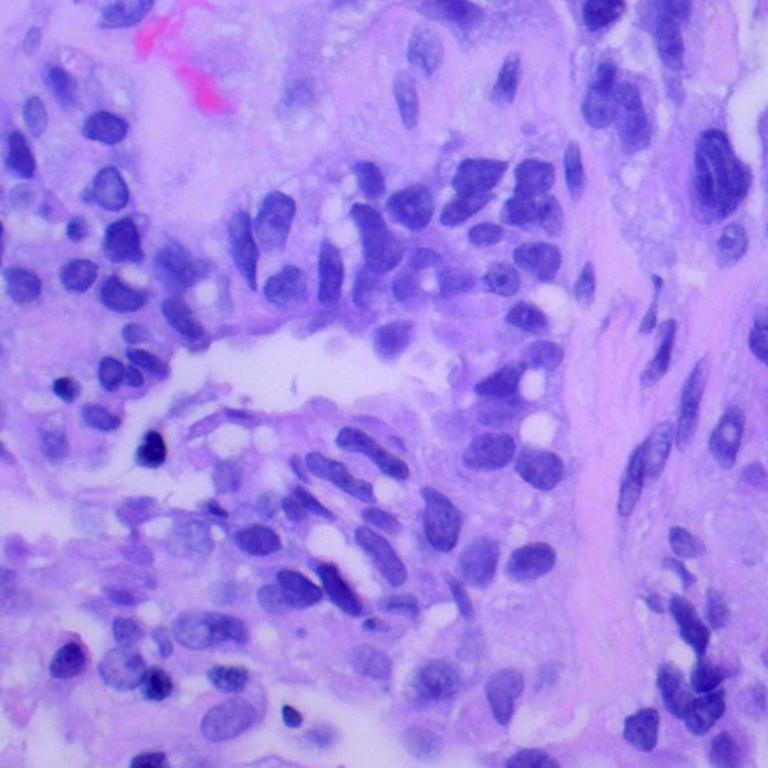

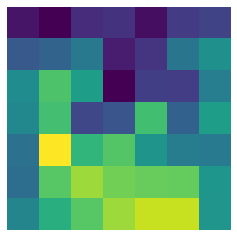

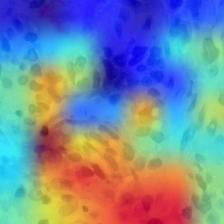

In [ ]:
#plot original image
display(Image(img_path))

#get image array and preprocessing
img = load_img(img_path, target_size=(224,224))
im_array = img_to_array(img)                           
im_array = im_array.reshape((1,) + im_array.shape)
im_array /=225.0

#calculate and plot heat map
heatmap = make_gradcam_heatmap(im_array, model, last_conv_layer,0 )
plt.matshow(heatmap)
plt.axis("off")
plt.show()

display_gradcam(im_array[0], heatmap)